In [51]:
import pickle
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.models import load_model
from sklearn.model_selection import train_test_split

First part of this notebook contains the evaluation of the models with the AUC on the test set. 

The second part of this notebook holds examples of text and image explainations (anomaly detection).

### 1) Evaluation

##### load in data

In [35]:
with open('data/text_processed.pkl', 'rb') as handle:
    text = pickle.load(handle)
    
with open('data/x_ray_processed.pkl', 'rb') as handle:
    img = pickle.load(handle)
    
original_data = pd.read_csv('data/ids_raw_texts_labels.csv')
# taking the intersection of ids of both datasets
ids   = list(set(list(text.keys())) & set(list(img.keys())))
raw_text = [original_data[original_data['ID'] == patient].Text.item() for patient in ids]
text  = [text[patient] for patient in ids]
img   = [img[patient] for patient in ids]
y     = [original_data[original_data['ID'] == patient].Labels.item() for patient in ids]

# Split the dataset for text
X_train_text, X_test_text, y_train, y_test = train_test_split(text, y, test_size=0.2, random_state=42)

# Split the dataset for img
X_train_img, X_test_img, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=42)

# random state is the same so same id splits go to both types of datasets
X_train_raw_text, X_test_raw_text, y_train, y_test = train_test_split(raw_text, y, test_size=0.2, random_state=42)

##### load models and weights

In [3]:
img_mod = load_model('best_models/img_model_final.h5')
txt_mod = load_model('best_models/text_model_final.h5')
mrg_mod = load_model('best_models/full_model_final.h5')

img_mod.load_weights('best_models/image_weights_final.hdf5')
txt_mod.load_weights('best_models/textfinal_weights_best.hdf5')
mrg_mod.load_weights('best_models/full_weights_best_final.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [8]:
pred = txt_mod.predict(np.array(X_test_text))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
print('Text Model AUC: {}'.format(round(metrics.auc(fpr, tpr),2)))

pred = img_mod.predict(np.array(X_test_img))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
print('Image Model AUC: {}'.format(round(metrics.auc(fpr, tpr),2)))

pred = mrg_mod.predict([np.array(X_test_img),np.array(X_test_text)])
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
print('Multimodal AUC: {}'.format(round(metrics.auc(fpr, tpr),2)))

Text Model AUC: 0.85
Image Model AUC: 0.74
Multimodal AUC: 0.86


### 2) Detection

#### Image Detection

In [21]:
from IntegratedGradients import *

def integrated_lesion (img, img_mod):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy
    import scipy.cluster.hierarchy as hcluster
    import math

    ig = integrated_gradients(img_mod)

    exp = ig.explain(img)
    
    lolnorm = cv2.normalize(exp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    gray = cv2.cvtColor(lolnorm, cv2.COLOR_BGR2GRAY)
    allx = gray
    gray[gray < 0.70]  = 0 
    
    d = pd.DataFrame(0, index=np.arange((224*224)), columns=['val', 'y', 'x'])
    
    index = 0 
    for i in range(224):
        for j in range(224):
            d.iloc[index,0] = gray[i,j]
            d.iloc[index,1] = i
            d.iloc[index,2] = j
            index += 1
    d = d[(d[['val']] != 0).all(axis=1)]       
    xs = d.x.values
    ys = d.y.values
    pairs = np.array([[i,j] for i, j in zip(xs,ys)])
    
    
    data = pairs


    # clustering
    thresh = 10
    clusters = hcluster.fclusterdata(data, thresh, criterion="distance")
    
    d['cluster'] = clusters
    d['dummy'] = 1
    
    centers = d.groupby(['cluster']).mean()
    counts = d.groupby(['cluster']).sum()

    relevent_clusters = list(counts[counts.dummy > 1].index)
    
    
    cv_centers = []
    cv_rads = []
    for i in relevent_clusters:
    
        x_cent = int(centers[centers.index == i].x)
        y_cent = int(centers[centers.index == i].y)
    
        cv_centers.append((x_cent, y_cent))
    
        temp_x = list(d[d.cluster == i].x)
        temp_y = list(d[d.cluster == i].y)
        dists = []
        for j in range(len(temp_x)):
        
            dists.append(math.hypot(y_cent - temp_y[j] , x_cent - temp_x[j]))
        
        cv_rads.append(max(dists) + 5)
        
    for i in range( len (cv_rads)):
        alpha = (cv2.circle(img,(cv_centers[i]),int(cv_rads[i]), 1))
        
    return(alpha, gray, allx)

In [22]:
y_test[125] # 125 .. Abnormal data sample

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


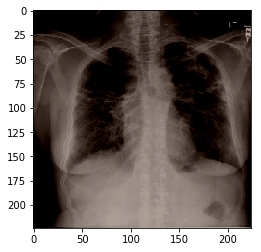

In [23]:
plt.imshow(X_test_img[125])

In [27]:
explaination_of_image = integrated_lesion(X_test_img[125], img_mod)
print('Image model: Patient has abnormality confidence of: {}'.format(img_mod.predict(np.array(X_test_img[125:127]))[0][0])

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


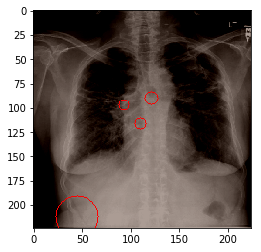

In [28]:
plt.imshow(explaination_of_image[0])

#### Text Detection

Continue with an easy note from the dataset

In [90]:
y_test[120]

0

In [91]:
X_test_raw_text[120]

'asthma. Cigarette smoking heart size is normal, lungs are clear. No nodular masses. CT scan is more sensitive in detecting small nodules. '

Treating the explaination as a picture and trying to find the highers gradients (as each row of the image represents a word)

/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



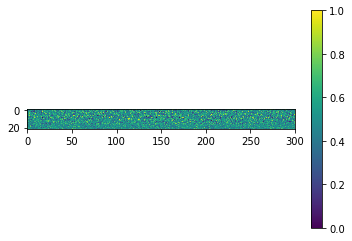

In [94]:
gradients = K.gradients(txt_mod.outputs, txt_mod.layers[1].output)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
evaluated_gradients = sess.run(gradients, feed_dict={txt_mod.input: np.asarray(X_test_text[120:122])})
evaluated_gradients[0].shape
a = evaluated_gradients[0][0]
a = a.reshape(42000)
norms = (a-min(a))/(max(a)-min(a))
testtext = X_test_raw_text[120]
op = len(testtext.split())
ff = norms.reshape([140,300])
qq = ff[0:op]

imgplot = plt.imshow(qq)
plt.colorbar()

Darker Colors suggest normality while lighter shades detect abnormalities. This Patient is a normal patient. Word combo of 'are clear' are fully dark and weigh in heavily to the 'normality' classification. If you hover-over the words, you will see the normalised weight of the words. One can also zoom in and out.

In [95]:
import plotly.figure_factory as ff
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='#plotlyUsrName', api_key='#PlotlyKey')
a = qq.sum(axis=1)
norms2 = (a-min(a))/(max(a)-min(a))
qqq = list(norms2)
symbol = [testtext.split()]
element = [qqq]
colorscale = [[0, '#66475e'], [1, '#ecbfe0']]
font_colors = ['#efecee', '#3c3636']
z = [list(norms2)]
hover= list(range(len(symbol)))
for x in range(len(symbol)):
    hover[x] = [i  for i in element[x]]

colorscale = [[0, '#66475e'], [1, '#ecbfe0']]
font_colors = ['#efecee', '#3c3636']    
    
# Invert Matrices
symbol = symbol[::-1]
hover = hover[::-1]
z = z[::-1]


# Make Annotated Heatmap
pt = ff.create_annotated_heatmap(z, annotation_text=symbol, text=hover,
                                 colorscale=colorscale, font_colors= font_colors, hoverinfo='text')
pt.layout.title = 'Doctor Notes'

py.iplot(pt, filename='periodic_table')